<a href="https://colab.research.google.com/github/GlazyevaValentina/Final_Project_GlazyevaVa/blob/main/Test/new_second_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import random
import tensorflow as tf
import keras

from PIL import Image
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from matplotlib import pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Potential solution for the problem above. Greetings from Michael :)
# Your daughter is doing great work!

# Get images
X = []
img_width, img_height = 256, 256  # Define the target image width and height

for filename in os.listdir('/content/gdrive/MyDrive/My Diploma/Train/'):
    img = load_img('/content/gdrive/MyDrive/My Diploma/Train/' + filename, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    X.append(img_array)

X = np.array(X, dtype=float)

# Set up train and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain


In [ ]:
#Design the neural network
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse')

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       1

In [ ]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model      
tensorboard = TensorBoard(log_dir="output2/first_run")
model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=1, steps_per_epoch=500)

500/500 [==============================] - 4987s 10s/step - loss: 0.0120


In [ ]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [ ]:
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

1/1 [==============================] - 0s 272ms/step - loss: 0.0128
0.012804876081645489


In [ ]:
color_me = []
for filename in os.listdir('/content/gdrive/MyDrive/My Diploma/Test/'):
    color_me.append(img_to_array(load_img('/content/gdrive/MyDrive/My Diploma/Test/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave('/content/gdrive/MyDrive/My Diploma/result/img_'+str(i)+'.png', lab2rgb(cur))

1/1 [==============================] - 2s 2s/step


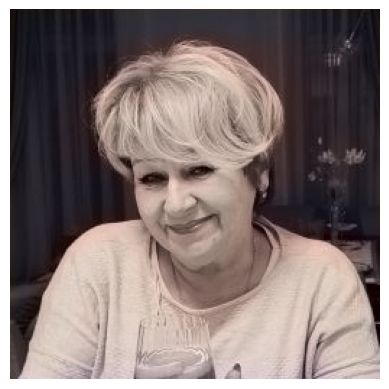

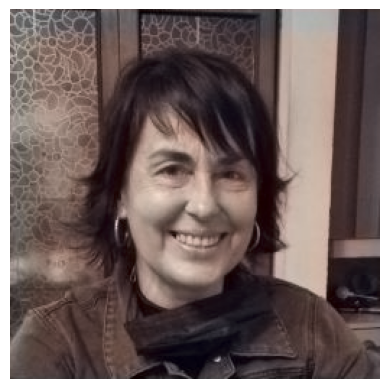

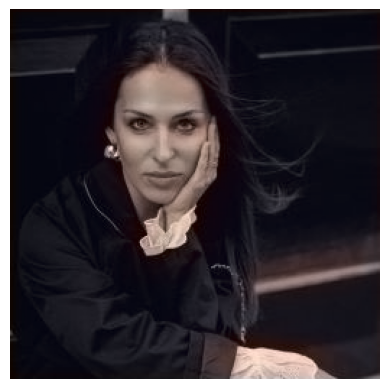

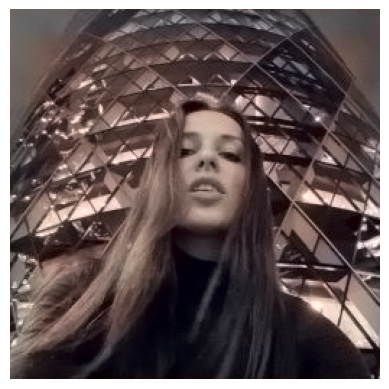

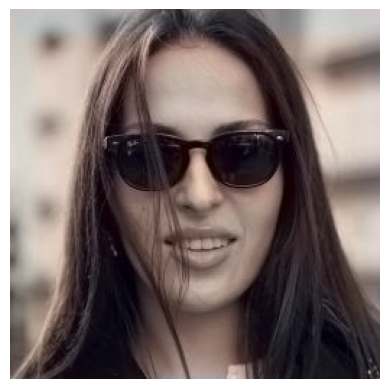

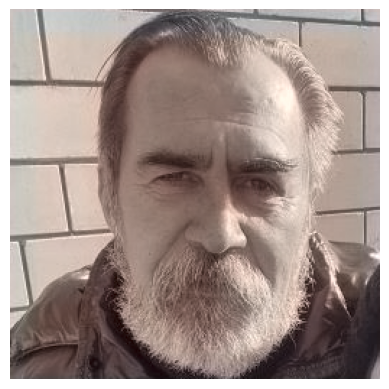

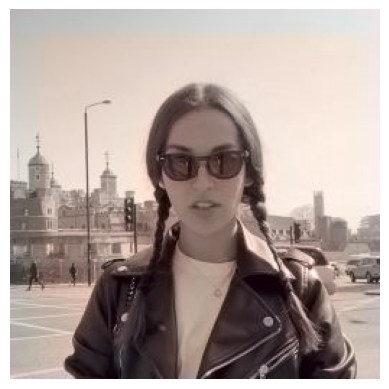

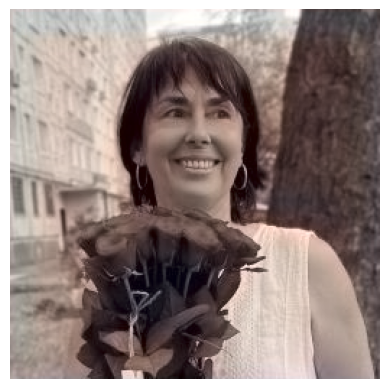

In [ ]:
import matplotlib.pyplot as plt
import os

path = "/content/gdrive/MyDrive/My Diploma/result"
images = os.listdir(path)

for image in images:
    img_path = os.path.join(path, image)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()